Silakan upload file dataset kamu (CSV/XLSX).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving data.csv to data (1).csv
File terdeteksi: data (1).csv
Shape awal: (13169, 13)
Kolom: ['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']
Kolom teks  : Tweet
Kolom label : HS
Distribusi label (awal):
label
0    7608
1    5561
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


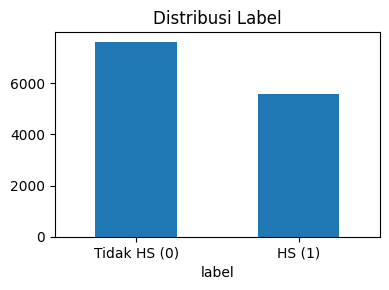

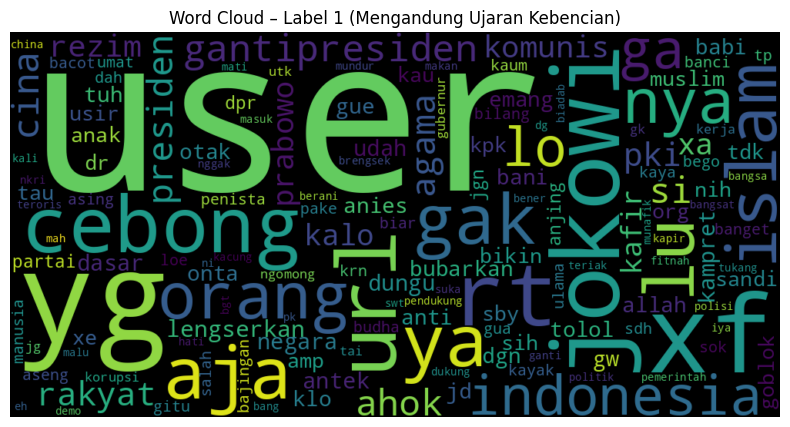


== Linear SVM (TF-IDF) ==
Accuracy : 0.8371
Precision: 0.7962
Recall   : 0.8255
F1-Score : 0.8106

Classification Report:
              precision    recall  f1-score   support

           0     0.8690    0.8456    0.8571      1522
           1     0.7962    0.8255    0.8106      1112

    accuracy                         0.8371      2634
   macro avg     0.8326    0.8356    0.8339      2634
weighted avg     0.8383    0.8371    0.8375      2634



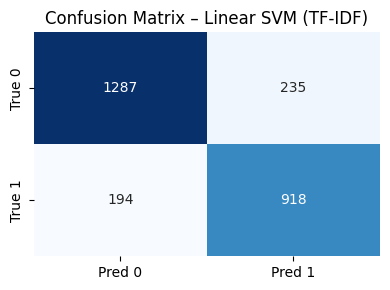


== Logistic Regression (TF-IDF) ==
Accuracy : 0.8390
Precision: 0.7940
Recall   : 0.8354
F1-Score : 0.8142

Classification Report:
              precision    recall  f1-score   support

           0     0.8750    0.8417    0.8580      1522
           1     0.7940    0.8354    0.8142      1112

    accuracy                         0.8390      2634
   macro avg     0.8345    0.8385    0.8361      2634
weighted avg     0.8408    0.8390    0.8395      2634



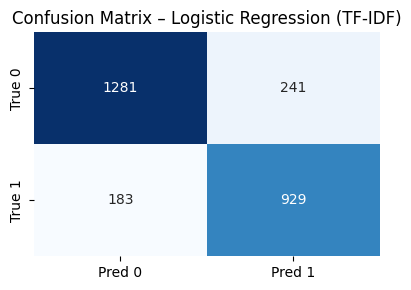


Artefak disimpan di folder 'artefak/': tfidf.pkl, linear_svm.pkl, logreg.pkl


In [2]:
# ==== Opsi: set nama kolom manual (biarkan None untuk auto-detect) ====
TEXT_COL  = None   # contoh: "tweet", "text", "komentar"
LABEL_COL = None   # contoh: "label", "HS", "is_hate"

# ==== Install & import ====
!pip -q install wordcloud Sastrawi charset-normalizer seaborn

import os, io, re, zipfile, glob, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")
from google.colab import files
from charset_normalizer import from_bytes
from wordcloud import WordCloud

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# NLTK & Sastrawi (opsional)
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
STOP_ID = set(stopwords.words("indonesian"))
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    STEMMER = StemmerFactory().create_stemmer()
except Exception:
    STEMMER = None

# ==== 1) Upload file dataset kamu ====
print("Silakan upload file dataset kamu (CSV/XLSX).")
uploaded = files.upload()
assert len(uploaded) > 0, "Tidak ada file yang di-upload."

fname = list(uploaded.keys())[0]
print("File terdeteksi:", fname)

# ==== 2) Baca file (anti-Unicode error) ====
def read_any(path_or_bytes, filename):
    if filename.lower().endswith((".xlsx", ".xls")):
        return pd.read_excel(io.BytesIO(path_or_bytes))
    else:
        raw = path_or_bytes if isinstance(path_or_bytes, (bytes, bytearray)) else open(filename,"rb").read()
        enc = (from_bytes(raw).best().encoding or "utf-8")
        txt = raw.decode(enc, errors="replace")
        # coba CSV
        try:
            return pd.read_csv(io.StringIO(txt))
        except Exception:
            # delimiter alternatif
            return pd.read_csv(io.StringIO(txt), sep=";")

df0 = read_any(uploaded[fname], fname)
print("Shape awal:", df0.shape)
print("Kolom:", list(df0.columns))

# ==== 3) Tentukan kolom teks & label ====
def autodetect_text_col(cols):
    candidates = ["text","tweet","komentar","comment","content","ulasan","review","message","body","Tweet","Text"]
    for c in candidates:
        for col in cols:
            if col.lower() == c.lower():
                return col
    # fallback: pilih kolom object terpanjang rata-rata
    obj_cols = [c for c in cols if df0[c].dtype == "object"]
    if obj_cols:
        lengths = {c: float(pd.Series(df0[c].astype(str)).str.len().mean()) for c in obj_cols}
        return max(lengths, key=lengths.get)
    return None

def autodetect_label_col(cols):
    # prioritas: HS, label, target, class, is_hate, hate, toxic
    preferred = ["HS","label","target","class","is_hate","hate","toxic","is_toxic"]
    for p in preferred:
        for col in cols:
            if col.lower() == p.lower():
                return col
    # cari kolom dengan nilai unik subset {0,1} atau {False,True}
    for col in cols:
        vals = pd.Series(df0[col]).dropna().unique()
        if set(pd.Series(vals).astype(str)).issubset({"0","1","True","False","true","false"}):
            return col
    return None

text_col  = TEXT_COL  or autodetect_text_col(df0.columns)
label_col = LABEL_COL or autodetect_label_col(df0.columns)

assert text_col is not None, f"Tidak menemukan kolom teks. Pilih salah satu dari: {list(df0.columns)} (atau set TEXT_COL)"
assert label_col is not None, f"Tidak menemukan kolom label biner. Pilih salah satu dari: {list(df0.columns)} (atau set LABEL_COL)"

print(f"Kolom teks  : {text_col}")
print(f"Kolom label : {label_col}")

# ==== 4) Bentuk label BINARY 0/1 (sesuai ketentuan) ====
df = df0[[text_col, label_col]].rename(columns={text_col:"text", label_col:"label"}).copy()
# Jika label bukan 0/1 (mis. string 'hate'/'non-hate' atau 0/1/2), konversi:
if df["label"].dtype == "O":
    # string: label=1 jika mengandung kata kunci
    df["label_bin"] = df["label"].astype(str).str.lower().str.contains(r"\bhate|kebenci|toxic|abusive|kasar\b")
    df["label"] = df["label_bin"].astype(int); df.drop(columns=["label_bin"], inplace=True)
else:
    # numerik
    # kalau ada nilai 2 (multi-kelas), anggap 1 hanya yg 'paling hate': jika ada kolom 'HS' terpisah, pakai itu,
    # kalau tidak, anggap 1 bila nilai == 1 (atau == 0 jika dataset seperti Davidson: class 0 = hate)
    uniq = sorted(pd.Series(df["label"]).dropna().unique())
    if set(uniq) - {0,1}:
        # heuristik: jika kolom HS ada di df0, pakai HS
        if "HS" in df0.columns:
            df["label"] = (df0["HS"].fillna(0).astype(int) == 1).astype(int)
        else:
            # fallback: jadikan 1 jika nilai==1, lainnya 0
            df["label"] = (df["label"] == 1).astype(int)

# bersihkan kosong
df.dropna(subset=["text"], inplace=True)
df["text"] = df["text"].astype(str)
print("Distribusi label (awal):")
print(df["label"].value_counts())

# ==== 5) Preprocessing teks ====
import nltk; nltk.download("stopwords")
RE_URL  = re.compile(r"(https?://\S+|www\.\S+)")
RE_USER = re.compile(r"@\w+")
RE_HASH = re.compile(r"#(\w+)")
RE_NUM  = re.compile(r"\d+")
USE_STEM = False  # set True jika ingin stemming Sastrawi

def clean_text(s: str) -> str:
    s = s.lower()                                 # case folding
    s = RE_URL.sub(" ", s)                        # hapus URL
    s = RE_USER.sub(" user ", s)                  # ganti mention
    s = RE_HASH.sub(r" \1 ", s)                   # buang '#'
    s = RE_NUM.sub(" ", s)                        # hapus angka
    s = re.sub(r"[^\w\s]", " ", s)                # hapus tanda baca
    s = re.sub(r"\s+", " ", s).strip()            # rapikan spasi
    # tokenisasi & stopword removal (ID)
    toks = [w for w in s.split() if w not in STOP_ID and len(w) > 1]
    s = " ".join(toks)
    if USE_STEM and STEMMER is not None and s:
        try:
            s = STEMMER.stem(s)
        except Exception:
            pass
    return s

df["text_clean"] = df["text"].apply(clean_text)
df = df[df["text_clean"].str.len() > 0].reset_index(drop=True)

# ==== 6) Visualisasi distribusi label ====
plt.figure(figsize=(4,3))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0,1], ["Tidak HS (0)", "HS (1)"], rotation=0)
plt.title("Distribusi Label"); plt.tight_layout(); plt.show()

# ==== 7) Word Cloud untuk label=1 ====
corpus_pos = " ".join(df.loc[df["label"]==1, "text_clean"])
if len(corpus_pos) > 0:
    wc = WordCloud(max_words=150, width=1000, height=500, collocations=False).generate(corpus_pos)
    plt.figure(figsize=(10,5)); plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
    plt.title("Word Cloud – Label 1 (Mengandung Ujaran Kebencian)"); plt.show()
else:
    print("Word cloud dilewati: tidak ada sampel label=1 setelah preprocessing.")

# ==== 8) Split data 80/20 ====
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# ==== 9) Representasi fitur: TF-IDF ====
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),  # unigram+bigram
    min_df=2
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# ==== 10) Model: Linear SVM (utama) + Logistic Regression (opsional) ====
svm = LinearSVC(class_weight="balanced", random_state=42)
svm.fit(Xtr, y_train)
pred_svm = svm.predict(Xte)

logreg = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
logreg.fit(Xtr, y_train)
pred_lr = logreg.predict(Xte)

# ==== 11) Evaluasi util & Confusion Matrix ====
import seaborn as sns
def evaluate(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    print(f"\n== {title} ==")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {pr:.4f}")
    print(f"Recall   : {rc:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    plt.title(f"Confusion Matrix – {title}")
    plt.tight_layout(); plt.show()

evaluate(y_test, pred_svm, "Linear SVM (TF-IDF)")
evaluate(y_test, pred_lr,  "Logistic Regression (TF-IDF)")

# ==== 12) (Opsional) Simpan artefak ====
import joblib, os
os.makedirs("artefak", exist_ok=True)
joblib.dump(tfidf, "artefak/tfidf.pkl")
joblib.dump(svm,   "artefak/linear_svm.pkl")
joblib.dump(logreg,"artefak/logreg.pkl")
print("\nArtefak disimpan di folder 'artefak/': tfidf.pkl, linear_svm.pkl, logreg.pkl")
